In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [24]:
multicore_out_path = "./results_multicore"

trace_name_list=['bzip2','gcc','milc','gromacs','cactusADM','leslie3d','namd','gobmk','dealII','soplex','hmmer','sjeng','GemsFDTD','libquantum','h264ref','lbm','omnetpp','astar','wrf','sphinx3','xalancbmk','mcf','zeusmp']

ipc_alone = {}

result_path = multicore_out_path + "/NoDefenseMap/stats/"
result_list = [x[:-4] for x in os.listdir(result_path) if (x.endswith(".txt") and x.startswith("256"))]
for result_filename in result_list:
    result_file = open(result_path + "/" + result_filename + ".txt", "r")
    trace = result_filename.split("_")[1]
    ipc_alone[trace] = [0 for _ in range(8)]
    for line in result_file.readlines():
        if (" cycles_recorded_core_0:" in line):
            ipc_alone[trace][0] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_1:" in line):
            ipc_alone[trace][1] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_2:" in line):
            ipc_alone[trace][2] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_3:" in line):
            ipc_alone[trace][3] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_4:" in line):
            ipc_alone[trace][4] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_5:" in line):
            ipc_alone[trace][5] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_6:" in line):
            ipc_alone[trace][6] = 100000000 / int(line.split(" ")[-1])
        elif (" cycles_recorded_core_7:" in line):
            ipc_alone[trace][7] = 100000000 / int(line.split(" ")[-1])
    result_file.close()

df = pd.DataFrame(columns=["mitigation", "trh", "trace", "ws"])
mitigation_list = ["Graphene", "MithrilDDR4", "MithrilCache8", "MithrilCache16", "MithrilCache32", "RRS"]
for mitigation in mitigation_list:
    result_path = multicore_out_path + "/" + mitigation + "/stats/"
    result_list = [x[:-4] for x in os.listdir(result_path) if x.endswith(".txt")]
    for result_filename in result_list:
        result_file = open(result_path + "/" + result_filename + ".txt", "r")
        trh = int(result_filename.split("_")[0])
        trace = result_filename.split("_")[1]
        ipc = [0 for _ in range(8)]
        for line in result_file.readlines():
            if (" cycles_recorded_core_0:" in line):
                ipc[0] = 100000000 / int(line.split(" ")[-1])
            elif (" cycles_recorded_core_1:" in line):
                ipc[1] = 100000000 / int(line.split(" ")[-1])
                
            elif (" cycles_recorded_core_2:" in line):
                ipc[2] = 100000000 / int(line.split(" ")[-1])
            elif (" cycles_recorded_core_3:" in line):
                ipc[3] = 100000000 / int(line.split(" ")[-1])
            elif (" cycles_recorded_core_4:" in line):
                ipc[4] = 100000000 / int(line.split(" ")[-1])
            elif (" cycles_recorded_core_5:" in line):
                ipc[5] = 100000000 / int(line.split(" ")[-1])
            elif (" cycles_recorded_core_6:" in line):
                ipc[6] = 100000000 / int(line.split(" ")[-1])
            elif (" cycles_recorded_core_7:" in line):
                ipc[7] = 100000000 / int(line.split(" ")[-1])

        # if (ipc[0] == 0 or ipc[1] == 0 or ipc[2] == 0 or ipc[3] == 0 or
        
        #     ipc[4] == 0 or ipc[5] == 0 or ipc[6] == 0 or ipc[7] == 0):
            

        if ipc_alone[trace][0] == 0:
            weighted_speedup = 0
        else:
            weighted_speedup = sum([ipc[i]/ipc_alone[trace][i] for i in range(8)]) / 8
        
        result_file.close()
        df = df.append({'mitigation': mitigation, 'trh': trh, 'trace': trace, 'ws': weighted_speedup}, ignore_index=True)
    
df = df.pivot(index=['trh', 'mitigation'], columns=['trace'], values='ws')
df.rename(columns={'MithrilDDR4': 'Mithril'}, inplace=True)
df.rename(columns={'MithrilCache': 'Mithril + Cache 64KB'}, inplace=True)


In [25]:
df.to_excel("res.xlsx")  

In [36]:
newdf = pd.DataFrame(columns=["mitigation", "trh", "ws"])

In [37]:
speedup = [[0.9508980726, 0.9827557323, 0.9965168209], [0.9270816219, 0.9658309623, 0.9867793869], 
[0.592149589, 0.7929822808, 0.9342448838], [0.4251780963, 0.7716842145, 0.9133487954], 
[0.9699521894, 0.9929087104, 1.005078608], [1.006287321, 1.006287321, 1.006287321]]

for i, mitigation in enumerate(["Graphene", "Mithril", "RRS", "BlockHammer", "Mithril+Cache-32", "LRU Cache"]):
    for j, trh in enumerate([256, 512, 1024]):
        newdf = newdf.append({'mitigation': mitigation, 'trh': trh, 'ws': speedup[i][j]}, ignore_index=True)

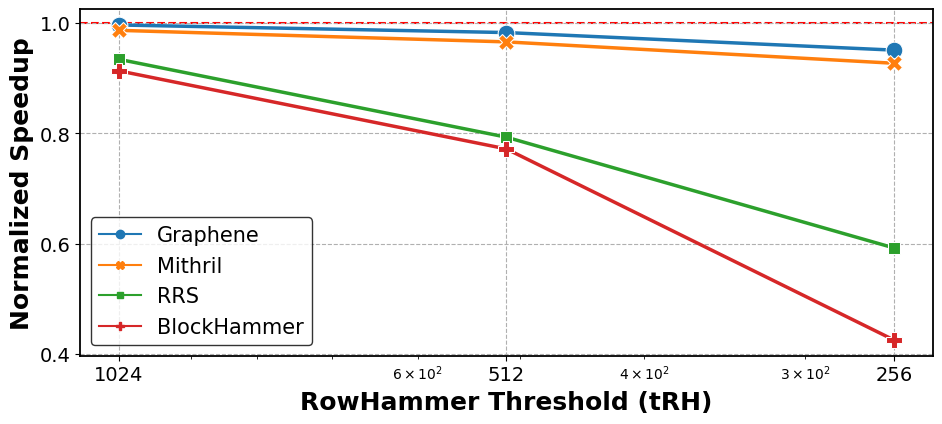

In [38]:
fig, ax = plt.subplots(figsize=(11, 4.5))

# plot the data as a line plot with markers and errorbars with larger markers and put ticks at both ends of the errorbars
sns.lineplot(x='trh', y='ws', hue='mitigation', data=newdf, ax=ax, 
             linewidth=2.5,
             markers=True, dashes=False, style='mitigation', markersize=12, errorbar=("sd"), err_style='bars',
             hue_order=["Graphene", "Mithril", "RRS", "BlockHammer", "Mithril+Cache-32", "LRU Cache"],
             err_kws={'capsize': 4, 'elinewidth': 2, 'capthick': 2}
             )

plt.grid(axis='both', linestyle='--')
#make x axis reversed
plt.gca().invert_xaxis()
plt.xscale('log')

x_ticks = [256, 512, 1024]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=14)

y_ticks = [0.4, 0.6, 0.8, 1.0]
ax.axhline(y=1.0, color='red', linestyle='--', zorder=0)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=14)

ax.set_xlabel("RowHammer Threshold (tRH)", fontsize=18, weight="bold")
ax.set_ylabel("Normalized Speedup", fontsize=18, weight="bold")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

# plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=6,
#             fontsize=12,
#             edgecolor='black'
#            )

plt.legend(loc='lower left', ncol=1,
            fontsize=15,
            edgecolor='black'
           )